In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.preprocessing import*
import datetime,time
from sklearn.metrics import*
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.options.display.float_format = '{:.7f}'.format
pd.set_option('display.max_columns', None)

### train_base

In [2]:
dftrain = pd.read_csv('D:/project/homecredit/train_base_v1.csv', index_col = 0)


obj_columns = dftrain.select_dtypes(include=['object']).columns
dftrain = pd.get_dummies(dftrain, columns=obj_columns, drop_first=True)

dftrain = dftrain.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x.replace(' ', '')))


X = dftrain.drop(columns=['SK_ID_CURR', 'TARGET'])
y = dftrain['TARGET']

### All_v2

In [16]:
dftrain = pd.read_csv('D:/project/homecredit/final/ETL_ALL_v2.csv', index_col = 0)

dftrain = dftrain.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x.replace(' ', '')))
dftrain = dftrain.loc[:, ~dftrain.columns.duplicated()]


X = dftrain.drop(columns=['SK_ID_CURR','TARGET'])
y = dftrain['TARGET']

### All_v1

In [3]:
df_all = pd.read_csv('D:/project/homecredit/train_all_v1.csv', index_col=0)


obj_columns = df_all.select_dtypes(include=['object']).columns
df_all = pd.get_dummies(df_all, columns=obj_columns, drop_first=True)

df_all = df_all.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x.replace(' ', '')))

X = df_all.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df_all['TARGET']


In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

迭代 10次，valid_0_AUC = 0.7449
迭代 20次，valid_0_AUC = 0.7523
迭代 30次，valid_0_AUC = 0.7555
迭代 40次，valid_0_AUC = 0.7589
迭代 50次，valid_0_AUC = 0.7625
迭代 60次，valid_0_AUC = 0.7659
迭代 70次，valid_0_AUC = 0.7685
迭代 80次，valid_0_AUC = 0.7711
迭代 90次，valid_0_AUC = 0.7733
迭代 100次，valid_0_AUC = 0.7752
迭代 110次，valid_0_AUC = 0.7770
迭代 120次，valid_0_AUC = 0.7788
迭代 130次，valid_0_AUC = 0.7801
迭代 140次，valid_0_AUC = 0.7814
迭代 150次，valid_0_AUC = 0.7826
迭代 160次，valid_0_AUC = 0.7836
迭代 170次，valid_0_AUC = 0.7848
迭代 180次，valid_0_AUC = 0.7854
迭代 190次，valid_0_AUC = 0.7861
迭代 200次，valid_0_AUC = 0.7867
迭代 210次，valid_0_AUC = 0.7872
迭代 220次，valid_0_AUC = 0.7876
迭代 230次，valid_0_AUC = 0.7880
迭代 240次，valid_0_AUC = 0.7885
迭代 250次，valid_0_AUC = 0.7890
迭代 260次，valid_0_AUC = 0.7892
迭代 270次，valid_0_AUC = 0.7894
迭代 280次，valid_0_AUC = 0.7899
迭代 290次，valid_0_AUC = 0.7902
迭代 300次，valid_0_AUC = 0.7906
迭代 310次，valid_0_AUC = 0.7907
迭代 320次，valid_0_AUC = 0.7911
迭代 330次，valid_0_AUC = 0.7912
迭代 340次，valid_0_AUC = 0.7914
迭代 350次，valid_0_AUC = 0

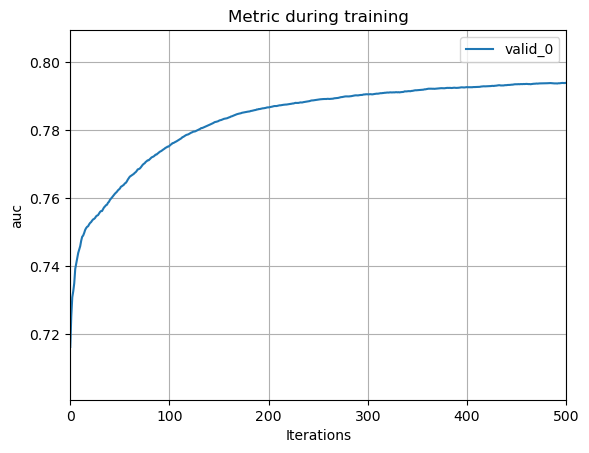

In [26]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)


params = {
    # 'objective': 'binary',
    # 'is_unbalance': 'true',
    # 'device': 'GPU',
    # 'n_estimators': 500,
    # 'metric': 'auc',
    # 'verbose': 1

            'nthread': 4,
            'is_unbalance': 'true',
            'n_estimators': 500,
            'learning_rate': 0.03,
            'num_leaves': 34,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 39.3259775,
            'silent': -1,
            'verbose': -1,
            # 'device': 'GPU'
}

evals_result = {}

start_time = time.time()

gbm = lgb.LGBMClassifier(**params)
gbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[lgb.record_evaluation(evals_result)],
)

end_time = time.time()
execution_time = end_time - start_time


# After training
for iteration, auc_values in enumerate(evals_result['valid_0']['auc'], start=1):
    if iteration % 10 == 0:  # Print every 10 iterations
        print(f'迭代 {iteration}次，valid_0_AUC = {auc_values:.4f}')


print("\n程式執行花費的时间：", round(execution_time, 2), "秒")
print("完成时间:", datetime.datetime.now())

# Plot the recorded evaluation metric (AUC)
lgb.plot_metric(evals_result, metric='auc')
plt.show()


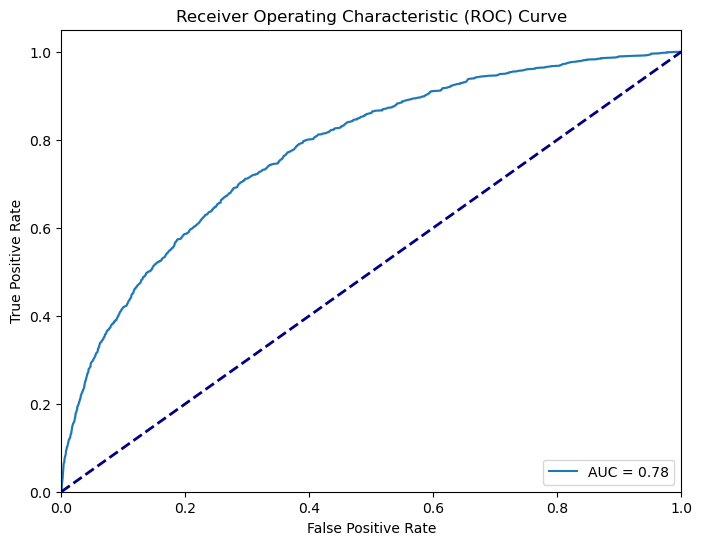

In [12]:
y_pred_prob = gbm.predict_proba(X_valid)[:, 1]

fpr, tpr, _ = roc_curve(y_valid, y_pred_prob)

roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

# 繪製AUC曲線
plt.figure(figsize=(8, 6))
sns.lineplot(data=roc_df, x='FPR', y='TPR', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Confusion Matrix:
[[10113  3990]
 [  392   881]]


<Axes: >

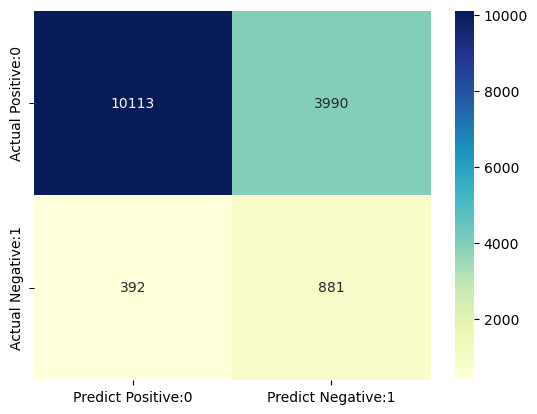

In [13]:
y_pred = gbm.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)

print("Confusion Matrix:")
print(cm)


cm_matrix = pd.DataFrame(data=cm, columns=['Predict Positive:0', 'Predict Negative:1'], 
                                 index=['Actual Positive:0', 'Actual Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<Figure size 2000x2000 with 0 Axes>

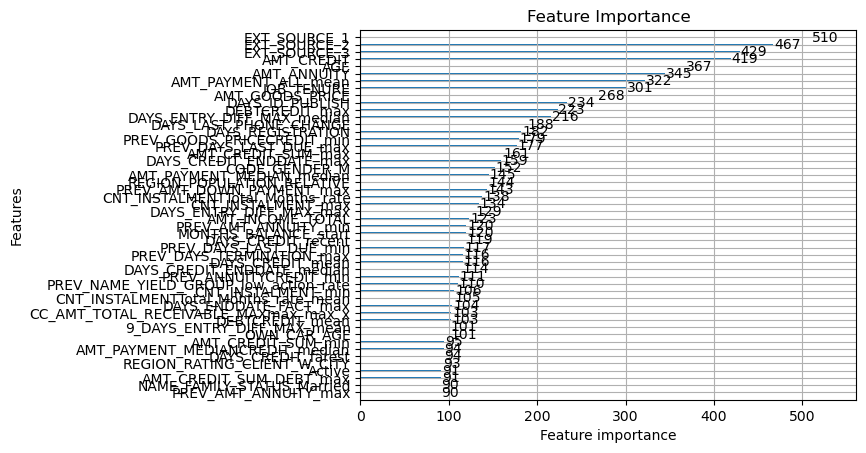

In [24]:
plt.figure(figsize=(20, 20))
lgb.plot_importance(gbm, max_num_features=50)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     14130
           1       0.08      0.31      0.13      1246

    accuracy                           0.65     15376
   macro avg       0.50      0.50      0.46     15376
weighted avg       0.85      0.65      0.73     15376

